In [4]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from neusa.experimentLib import *
from neusa.funcs import *
from neusa.spikes import *
import neusa.experimentTools as et

In [6]:
path_to_data = 'data/mnist_reduced.pkl.gz'

Helping functions: 

In [7]:
def exp_prob_beta_gamma(dt, beta, g_leak, gamma, t_ref):
    def func(V):
        return np.random.rand( len(V) ) < (1-np.exp(-np.exp(V*beta*g_leak+np.log(gamma))*float(dt)))
    return func

def load_mnist_data(min_p = 1e-4, max_p=.95, binary=False, seed=None, n_classes = range(10)):
    #------------------------------------------ Create Input Vector
    
    mnist_data = load_MNIST(n_samples,
                            min_p = min_p,
                            max_p = max_p,
                            binary = binary,
                            seed = seed, 
                            num_classes = n_classes)
    iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = mnist_data
    return iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l

def bound_data(data, min_p = 0.0001, max_p = .95, binary = False):
    if not binary:
        max_p_ = max_p
        min_p_ = min_p
    else:
        max_p_ = 0.5
        min_p_ = 0.5
    data[data >= max_p_] = max_p
    data[data < min_p_] = min_p
    
def select_equal_n_labels(n, data, labels, classes = None, seed=None):
    if classes is None:
        classes = range(10)    
    n_classes = len(classes)
    n_s = np.ceil(float(n)/n_classes)
    max_i = [np.nonzero(labels==i)[0] for i in classes]
    if seed is not None:
        np.random.seed(seed)
    f = lambda x, n: np.random.randint(0, int(x)-1, int(n))
    a = np.concatenate([max_i[i][f(len(max_i[i]), n_s)] for i in classes])
    np.random.shuffle(a)
    iv_seq = data[a]
    iv_l_seq = labels[a]
    return iv_seq, iv_l_seq   

def load_MNIST(n_samples, min_p = 0.0001, max_p = .95, binary = False, seed=None, datafile = path_to_data, num_classes = range(10)):
    import gzip, pickle
    mat = pickle.load(gzip.open(datafile, 'r'), encoding='latin1')

    train_iv = mat['train']
    train_iv_l = mat['train_label']
    test_iv = mat['test']
    test_iv_l = mat['test_label']
    
    bound_data(train_iv, min_p, max_p, binary)
    bound_data(test_iv, min_p, max_p, binary)
    
    iv_seq, iv_l_seq = select_equal_n_labels(n_samples, train_iv, train_iv_l, seed = seed, classes=num_classes)
    
    return iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l



More helper functions: 

In [8]:
def clamped_input_transform(input_vector, min_p=1e-7, max_p=0.999):
    s = np.array(input_vector) #Divide by t_ref to get firing rates
    s[s<min_p] = min_p
    s[s>max_p] = max_p
    s =  -np.log(-1+1./(s))
    return s

def create_pId(iv_seq, iv_l_seq, N_v, N_c, n_c_unit, min_p = .00001, max_p = .95):
    Id = np.ones([iv_seq.shape[0], iv_seq.shape[1]+N_c])*min_p
    
    for i in range(iv_seq.shape[0]):
        cl = np.zeros(N_c)
        cl[int(iv_l_seq[i]*n_c_unit):int((iv_l_seq[i]+1)*n_c_unit)] = max_p
        Id[i,N_v:] = clamped_input_transform(cl, min_p = min_p, max_p = max_p)
        Id[i,:N_v] = clamped_input_transform(iv_seq[i,:], min_p = min_p, max_p = max_p)

    return Id

def create_Id(data = True, c_min_p = 1e-4, c_max_p = .95, seed = None):
    if hasattr(data, '__len__'):
        iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = data
        Idp = create_pId(iv_seq, iv_l_seq, N_v, N_c, n_c_unit, min_p = c_min_p, max_p = c_max_p)
        Id = (Idp /beta)
    elif data == True:
        iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = load_mnist_data(seed = seed)
        Idp = create_pId(iv_seq, iv_l_seq, N_v, N_c, n_c_unit, min_p = c_min_p, max_p = c_max_p)
        Id = (Idp /beta)
    else:
        Id = np.zeros([n_samples,N_v+N_c])  
    return Id

def classification_free_energy(Wvh, Wch, b_h, b_c, test_data, test_labels, n_c_unit, n_classes = 10):
    numcases = len(test_labels);
    F = np.zeros([int(numcases), int(n_classes)]);
    for i in range(n_classes):
        X= np.zeros([int(numcases), int(n_c_unit)*int(n_classes)]);
        X[:, int(n_c_unit*i):int(n_c_unit*(i+1))] = 1;
        F[:,i] = np.tile(b_c[i],numcases)*X[:,i]+\
                 np.sum(np.log(np.exp(np.dot(test_data, Wvh)+np.dot(X,Wch)+np.tile(b_h,numcases).reshape(numcases,-1))+1), axis=1);
    prediction= np.argmax(F, axis=1);
    accuracy = sum(prediction==test_labels)/numcases # changed from: 1-float(sum(prediction!=test_labels))/numcases
    assert 1>=accuracy>=.1/n_classes
    return accuracy, prediction!=test_labels

def monitor_to_spikelist(Ms):
    if len(Ms.spikes)>0:
        s = np.array(Ms.spikes)
        id_list = range(len(Ms.source))
        s[:,1] = s[:,1] * 1000 #SpikeList takes ms
        return spikes.SpikeList(spikes = s, id_list = id_list)
    else:
        return spikes.SpikeList(id_list = id_list)

In [9]:
#class CountingEventClock(Clock):
#    def __init__(self, period, mod = 100, *args, **kwargs):
#        self.n = 0
#        self.tmod = 0
#        self.mod = mod
#        self.period = period
#        dt= period/mod
#        #Clock.__init__(self, dt)
#        super().__init__(dt)
#                 
#    def step(self):
#        tmod_now, n_now = self.tmod, self.n
#        self.tmod = np.mod(self.tmod+1, self.mod)
#        self.n = int(self.t/(self.period))
#        return tmod_now, n_now

#period = dcmt*t_ref
#mod = 100
#ev = Clock(period/mod)
#ev.add_attribute(name = "n")
#ev.add_attribute(name = "tmod")
#ev.add_attribute(name = "mod")
#ev.add_attribute(name = "period")
#ev.n = 0
#ev.tmod = 0
#ev.mod = mod
#ev.period = period

def custom_step(clock_object):
    tmod_now, n_now = clock_object.tmod, clock_object.n
    clock_object.tmod = np.mod(clock_object.tmod+1, clock_object.mod)
    clock_object.n = int(clock_object.t/(clock_object.period))
    return tmod_now, n_now
    

In [10]:
def create_bias_vectors(N_v, N_c, N_h):
    bias_v = b_v = np.zeros(N_v)
    bias_h = b_h = np.zeros(N_h)
    bias_c = b_c = np.zeros(N_c)
    return b_v, b_c, b_h    

def create_weight_matrix(N_v, N_h, N_c, sigma = 0.1):
    return np.random.normal(0, sigma, size=(N_v+N_c, N_h))

def create_rbm_parameters(wmean=0, b_vmean=0, b_hmean=0):
    #------------------------------------------ Bias and weights
    b_v, b_c, b_h = create_bias_vectors(N_v, N_c, N_h)
    Whv = create_weight_matrix(N_v, N_h, N_c, sigma = 0.1)    
    Whv+= wmean
    b_v+= b_vmean
    b_h+= b_hmean
    return Whv, b_v, b_c, b_h

In [11]:
# Equations: 
eqs_str_lif_wnrd = '''
dv/dt = (-g_leak*v + i_inj + I_rec + wnsigma*xi*t_ref**0.5 + I_d)/Cm :volt
dI_rec/dt = -I_rec/tau_rec : amp
I_d : amp
'''

eqs_str_lif_wnr = '''
dv/dt = (-g_leak*v + i_inj + I_rec + wnsigma*xi*t_ref**0.5)/Cm :volt
dI_rec/dt = -I_rec/tau_rec : amp
'''

In [12]:
ion() #Necessary for performance plots
def main(Whv, b_v, b_c, b_h, Id, dorun = True, monitors=True, display=False, mnist_data = None):
    #defaultclock.reinit()
    start_scope()
    b_init = np.concatenate([b_v, b_c, b_h])
    netobjs = []
    #------------------------------------------ Neuron Groups
    print("Creating equation")
    
    eqs_v = Equations(eqs_str_lif_wnrd, 
            Cm = 1e-12*farad,
            I_inj = i_inj,
            g = g_leak,
            sigma = wnsigma,
            tau_rec = tau_rec)
                                               
    eqs_h = Equations(eqs_str_lif_wnr, 
            Cm = 1e-12*farad,
            I_inj = i_inj,
            g = g_leak,
            sigma = wnsigma,
            tau_rec = tau_rec)
    
    print("Creating Population")
    neuron_group_rvisible = NeuronGroup(\
            N_v+N_c,
            model = eqs_v,
            threshold = 'v>theta', # removed * volt
            refractory = t_ref,
            reset = "v = 0*volt"  # changed to string
            )
    
    neuron_group_rhidden = NeuronGroup(\
            N_h,
            model = eqs_h,
            threshold = 'v>theta',# removed * volt
            refractory = t_ref,
            reset = "v = 0*volt"  # changed to string
            )


    netobjs += [neuron_group_rvisible, neuron_group_rhidden]
    
    #--------------------------- Custom Network Operations
#   @network_operation(clock = defaultclock)
#   def update_mpot(when='after'):
#       neuron_group_rvisible.v[neuron_group_rvisible.v<=0.0*volt]=0.0*volt
#       neuron_group_rhidden.v[neuron_group_rhidden.v<=0.0*volt]=0.0*volt
#   netobjs.append(update_mpot)   
    
    #Bias group
    Bv = PoissonGroup(N_v+N_c, rates = bias_input_rate) #Noise injection to h
    Bh = PoissonGroup(N_h, rates = bias_input_rate) #Noise injection to h
    
    netobjs+=[Bv,Bh]
    
    #---------------------- Initialize State Variables
    neuron_group_rvisible.I_d = 0. * amp
    
    
    #---------------------- Connections and Synapses
    #Bias units    
    Sbv = Synapses(Bv, neuron_group_rvisible, 
              model='''Afre : 1
                     Afost : 1
                     g : 1
                     w : 1
                     lastupdate : second''',
                on_pre ='''Afre=Afre*exp((lastupdate-t)/tau_learn)
                          Afost=Afost*exp((lastupdate-t)/tau_learn)
                          Afre+=deltaAbias
                          w=w+g*Afost
                          I_rec_post+= w * amp
                          lastupdate = t''',
                on_post='''Afre=Afre*exp((lastupdate-t)/tau_learn)
                          Afost=Afost*exp((lastupdate-t)/tau_learn)
                          Afost+=deltaAbias
                          w=w+g*Afre
                          lastupdate = t'''
                          )
    Sbv.connect(j='i')
    #Sbv[:,:] = 'i==j'

    Sbv.w[:] = np.concatenate([b_v,b_c])/beta/bias_input_rate/tau_rec
    
    Sbh = Synapses(Bh, neuron_group_rhidden, 
              model='''Afre : 1
                     Afost : 1
                     g : 1
                     w : 1
                     lastupdate : second''',
                on_pre ='''Afre=Afre*exp((lastupdate-t)/tau_learn)
                          Afost=Afost*exp((lastupdate-t)/tau_learn)
                          Afre+=deltaAbias
                          w=w+g*Afost
                          I_rec_post+= w * amp
                          lastupdate = t''',
                on_post='''Afre=Afre*exp((lastupdate-t)/tau_learn)
                          Afost=Afost*exp((lastupdate-t)/tau_learn)
                          Afost+=deltaAbias
                          w=w+g*Afre
                          lastupdate = t'''
                          )
    Sbh.connect(j='i')
    #Sbh[:,:] = 'i==j'

    Sbh.w[:] = b_h[:]/beta/bias_input_rate/tau_rec
    
    Srs=Synapses(neuron_group_rvisible, neuron_group_rhidden,
        model='''Afre : 1
                 Afost : 1
                 g : 1
                 w : 1
                 lastupdate : second''',
            on_pre =''' Afre=Afre*exp((lastupdate-t)/tau_learn)
                        Afost=Afost*exp((lastupdate-t)/tau_learn)
                        Afre+=deltaA
                        I_rec_post+= w * amp
                        w=w+g*Afost''',
            on_post='''Afre=Afre*exp((lastupdate-t)/tau_learn)
                    Afost=Afost*exp((lastupdate-t)/tau_learn)
                    Afost+=deltaA
                    I_rec_pre+= w * amp
                    w=w+g*Afre'''
                    )
    Srs.connect()
    #Srs[:,:] = True

    M_rec = Whv/beta
    for i in range(M_rec.shape[0]):
        Srs.w[i,:] = M_rec[i,:]
    
    
    netobjs+=[Sbv,Sbh,Srs]

    #ev = CountingEventClock(period = dcmt*t_ref)
    
    period = dcmt*t_ref
    mod = 100
    ev = Clock(period/mod)
    ev.add_attribute(name = "n")
    ev.add_attribute(name = "tmod")
    ev.add_attribute(name = "mod")
    ev.add_attribute(name = "period")
    ev.n = 0
    ev.tmod = 0
    ev.mod = mod
    ev.period = period


    # Each epoch consists of a LTP phase during which the data is presented (construction), 
    # followed by a free- running LTD phase (reconstruction). The weights are updated asynchronously 
    # during the time interval in which the neural sampling proceeds.

    @network_operation(clock = ev)
    def g_update(when='after'):
        tmod, n = custom_step(ev)
        if tmod < 50:   # while below 50 cycles, clamp data to visible units. Otherwise input current = 0 
                        # below 50 is data phase, above 50 is reconstruction phase
            neuron_group_rvisible.I_d = Id[n] * amp
        else:
            neuron_group_rvisible.I_d = 0. * amp
    
        if tmod<=int(t_burn_percent): # while time is within burn in timeframe, set g = 0 (no stdp takes place)
            Srs.g = 0. # synapses connecting hidden and visible 
            Sbh.g = Sbv.g = 0. # synapses connecting biases to hidden/ visible layers 

        elif int(t_burn_percent)<=tmod<49: # if time is higher than burn in but lower than 50 cycles: g = 1, meaning 
            g_up = 1.
            Srs.g = Sbv.g = Sbh.g =  g_up
            
        elif 49<=tmod < 50+int(t_burn_percent):
            Srs.g = Sbv.g = Sbh.g = +0.
            
        elif 50+int(t_burn_percent) <= tmod <99:
            g_down = -1.
            Srs.g = Sbv.g = Sbh.g = g_down
            
        elif 99<= tmod:
            Srs.g = 0.
            Sbh.g = Sbv.g = 0.
    
        if tmod==50:
            #neuron_group_rvisible.I_DATA=0
            Srs.Afre=0
            Srs.Afost=0
            Sbv.Afre=0
            Sbv.Afost=0
            Sbh.Afre=0
            Sbh.Afost=0

    netobjs += [g_update]
        
    w_hist_v = []
    w_hist_c = []
    b_hist_vc = []
    b_hist_h = []
    
    if display:
        iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = mnist_data
        figure()
        res_hist_test=[]
        res_hist_train=[]
        test_data = test_iv
        test_labels = test_iv_l
        train_data = train_iv[:200]
        train_labels = train_iv_l[:200]
        plot_every = 10
        
        @network_operation(clock=Clock(dt=plot_every*dcmt*t_ref))
        def plot_performance(when='after'):    
            n = ev.n
            #Wt = Srs.w.data.reshape(N_v+N_c,N_h)
            Wt = np.array(Srs.w).reshape(N_v+N_c, N_h)
            w_hist_v.append(Wt[:N_v,:].mean())
            w_hist_c.append(Wt[N_v:,:].mean())
            # b_hist_vc.append(Sbv.w.data.mean())
            b_hist_h.append(np.array(Sbv.w).mean())
            # b_hist_h.append(Sbh.w.data.mean())
            b_hist_h.append(np.array(Sbh.w).mean())
            #W=Srs.w.data.copy().reshape(N_v+N_c, N_h)*beta
            W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta
            Wvh=W[:N_v,:]
            Wch=W[N_v:,:]
            #mBv = Sbv.w.data*beta*tau_rec*bias_input_rate
            mBv = np.array(Sbv.w)*beta*tau_rec*bias_input_rate
            #mBh = Sbh.w.data*beta*tau_rec*bias_input_rate
            mBh = np.array(Sbh.w)*beta*tau_rec*bias_input_rate
            b_c = mBv[N_v:(N_v+N_c)]
            b_v = mBv[:N_v]
            b_h = mBh
            mB = np.concatenate([mBv,mBh])
    
            accuracy_test = classification_free_energy(Wvh, Wch, b_h, b_c, test_data, test_labels, n_c_unit)[0]    
            res_hist_test.append(accuracy_test)
            
            accuracy_train = classification_free_energy(Wvh, Wch, b_h, b_c, train_data, train_labels, n_c_unit)[0]
            res_hist_train.append(accuracy_train)
        
            clf()
            plot(res_hist_train, 'go-', linewidth=2)
            plot(res_hist_test, 'ro-', linewidth=2)
            axhline(0.1)
            axhline(0.85)
            axhline(0.9, color='r')
            xlim([0,t_sim/(plot_every*dcmt*t_ref)])
            ylim([0.0,1])
            a=plt.axes([0.7,0.1,0.2,0.2])
            a.plot(w_hist_v,'b.-')
            a.plot(w_hist_c,'k.-')
            a.plot(b_hist_vc,'g.-')
            a.plot(b_hist_h,'r.-')
        
            print(accuracy_test)
            draw()
        
        netobjs += [plot_performance]
    
    #--------------------------- Monitors
    if monitors:
        Mh=SpikeMonitor(neuron_group_rhidden)
        Mv=SpikeMonitor(neuron_group_rvisible)
        netobjs += [Mh, Mv]
    #MId = StateMonitor(neuron_group_rvisible, varname='I_d', record=True)
    #MIt = StateMonitor(Sbh,varname='g',record=[0])
    net = Network(netobjs)
    if dorun:
        import time
        tic = time.time()      
        net.run(t_sim)
        toc = time.time()-tic
        print(toc)
        
    return locals()

In [13]:
# Parameters: 

n_classes = 10
N_v = N_inputs =784
N_c = N_class = 40
N_h = N_hidden =500

n_c_unit =  N_c/n_classes

dcmt = 35 #35 #duty cyle in multiples of t_ref

#----------------------------------------- Neuron parameters
t_ref = 0.004 * second
t_sim = dcmt*t_ref*10000    #originally: *10000 # second
bias_input_rate = 1000. * Hz
beta = 2.04371561e+09 # 1/amp
gamma = np.exp(9.08343441e+00)* Hz
tau_noise = .001 * ms
tau_rec = t_ref
theta = .1 * volt 
cm = 1e-12 #* farad
beta_fi = 1./cm/theta
sigma = 1.e-9 * amp
cal_i_lk = 0.0e-10
g_leak = 1e-9 * siemens
dt = 0.00005 * second
n_samples = t_sim/(dcmt*t_ref)+1
wnsigma = 4.24e-11 * amp

t_burn_percent = 10.
tau_learn = t_ref

deltaT = ((0.49-t_burn_percent/100)*dcmt*t_ref)

eta = 32e-3
epsilon = eta/beta*t_ref**2
epsilon_bias = eta/beta*t_ref*(1./bias_input_rate)

deltaA  = eta/beta/tau_learn/deltaT*t_ref**2/2
deltaAbias = eta/beta/tau_learn/deltaT*t_ref*(1./bias_input_rate)/2 

i_inj = (- np.log(float(gamma))
         - np.log(float(t_ref))
         )/beta * amp

defaultclock.dt = dt 



In [14]:
mnist_data = load_mnist_data(min_p = .00001, max_p = .98, binary = True, seed=0#, n_classes=range(1)
                             )

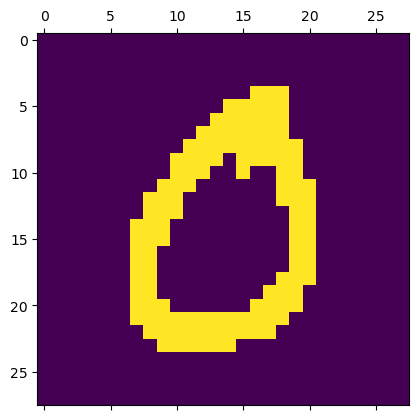

In [15]:
example = 0
plt.matshow(mnist_data[0][mnist_data[1] == example][0].reshape(28, 28))

In [16]:
Id = create_Id(mnist_data, c_min_p = .00001, c_max_p = .98)
W, b_v, b_c, b_h = create_rbm_parameters()

Creating equation
Creating Population


INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109/var
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109/var/folders
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109/var/folders/07
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_4hxw3109
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew

0.074


KeyboardInterrupt: 

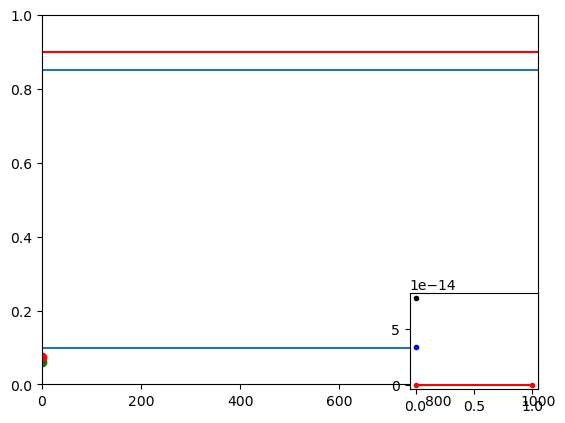

In [17]:
loc = main(W, b_v, b_c, b_h, Id = Id, dorun = True, monitors = True, display=True, mnist_data=mnist_data)

In [ ]:
locals().update(loc) # important!

In [ ]:
#W=Srs.w.data.copy().reshape(N_v+N_c, N_h)*beta
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
#mBv = Sbv.w.data*beta*tau_rec*bias_input_rate
mBv = np.array(Sbv.w)*beta*tau_rec*bias_input_rate
#mBh = Sbh.w.data*beta*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

In [ ]:
Mv.all_values()["t"][0]

array([], dtype=float64) * second

<AxesSubplot: xlabel='time (ms)', ylabel='neuron index'>

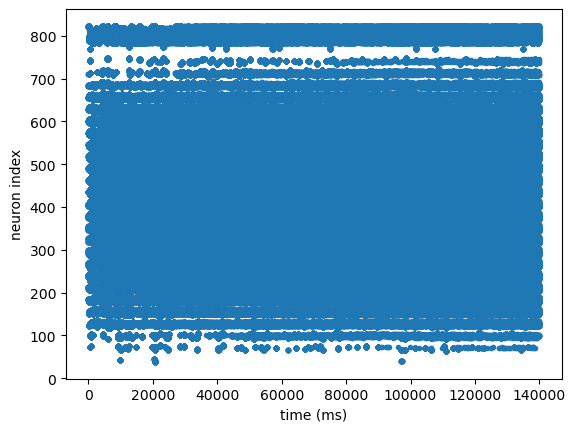

In [ ]:
brian_plot(Mv)

In [ ]:
d = et.mksavedir()
et.save_file(__file__)
et.globaldata.W = W
et.globaldata.mB = mB

try:
    et.globaldata.Mv = monitor_to_spikelist(Mv)
    et.globaldata.Mh = monitor_to_spikelist(Mh)
except NameError:
    print("SpikeMonitors are not defined")

et.globaldata.res_hist_train = res_hist_train 
et.globaldata.res_hist_test = res_hist_test 
et.globaldata.w_hist_v   = w_hist_v
et.globaldata.w_hist_c   = w_hist_c
et.globaldata.b_hist_vcn = res_hist_train
et.globaldata.b_hist_h   = res_hist_test 
et.save({'Wh':Wvh, 'Wc':Wch, 'b_vch': mB}, 'WSCD.pkl')
et.save()
et.savefig('progress.png', format='png')

WARNING    /Users/daniel/Documents/Arbeit/Uni/Thesis/Code/eCD/neusa/experimentTools.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ratio is 'g':
 [py.warnings]
  if ratio is 'g':

WARNING    /Users/daniel/Documents/Arbeit/Uni/Thesis/Code/eCD/neusa/experimentTools.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif ratio is 's':
 [py.warnings]
  elif ratio is 's':

WARNING    /Users/daniel/Documents/Arbeit/Uni/Thesis/Code/eCD/neusa/experimentTools.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ratio is 'g':
 [py.warnings]
  if ratio is 'g':

WARNING    /Users/daniel/Documents/Arbeit/Uni/Thesis/Code/eCD/neusa/experimentTools.py:44: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif ratio is 's':
 [py.warnings]
  elif ratio is 's':



NameError: name 'file' is not defined